In [1]:
import math

import numpy as np
import scipy.stats as ss
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline

from scipy import sparse
from scipy.sparse.linalg import splu
from scipy.sparse.linalg import spsolve

import warnings
warnings.filterwarnings("ignore")

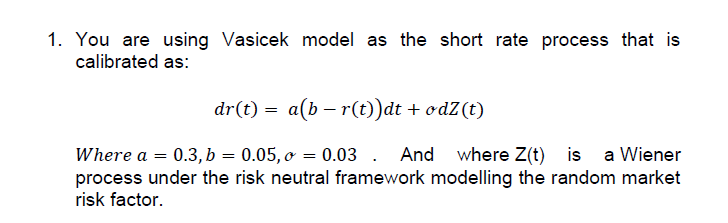

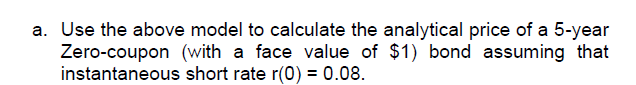

In [2]:
def ZCB(r0, kappa, tau, sigma, theta):
    B = (1 - np.exp(-kappa * tau)) / kappa

    A = (theta - (sigma ** 2) / (2 * (kappa ** 2))) * (B - tau) - (sigma ** 2) / (4 * kappa) * (B ** 2)

    zero_price = np.exp(A) * np.exp(-r0 * B)

    return zero_price

In [3]:
print('Analytical Price of Zero Coupon Bond is :', round(ZCB(0.08,0.3,5,0.03,0.05),5))

Analytical Price of Zero Coupon Bond is : 0.72567


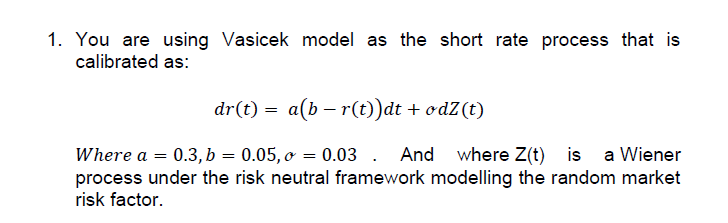

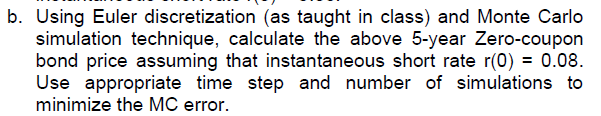

In [4]:
def Vasicek_paths(r0, kappa, theta, sigma, T, M, I):

        ''' Parameters

             ==========

            r0: instantaneous spot rate

            kappa: mean-reversion factor

            theta: long-run mean

            sigma: volatility factor

            T: final date/time horizon

            M: number of time steps

            I: number of paths
            '''

        dt = T / M

        r = np.zeros((M + 1, I), dtype=np.float64)

        r[0] = r0

        rh = np.zeros_like(r)

        rh[0] = r0

        np.random.seed(10)

        ran = np.random.standard_normal((M + 1, I))

        for t in range(1, M + 1):

            rh[t] = (rh[t - 1] + kappa * (theta -  rh[t - 1])

                     * dt + sigma * ran[t] * math.sqrt(dt))

            r[t] = rh[t]

        return r
    
def zcb_price(r0, kappa, theta, sigma, T, M, I):
    dt = T / M

    r = Vasicek_paths(r0, kappa, theta, sigma, T, M, I)

    zcb = np.zeros((M + 1, I), dtype=np.float64)

    zcb[-1] = 1.0  # Face value of bond assigned to entire row

    for t in range(M, 0, -1):
        zcb[t - 1] = zcb[t] * np.exp(-(r[t] + r[t - 1]) / 2 * dt)

        ZCB_cashflow = np.sum(zcb, axis=1) / I  #This will be average cash flow of ZCB equivalent to time step M

    return ZCB_cashflow[0]

In [5]:
print('Simulated price of zero coupon bond is :', round(zcb_price(0.08, 0.5, 0.05,0.03,5,1000,20000),2))

Simulated price of zero coupon bond is : 0.74


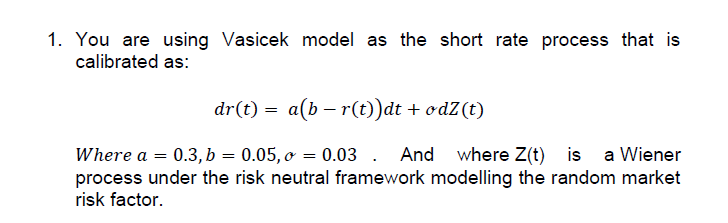


In [6]:
def Swap_Rate(r0, kappa, tau, sigma, theta):
    j=tau
    
    CF=np.zeros((j,),dtype=np.float64)

    for t in range(j,0,-1):

            #Calculating bond with different maturity using affine model

            #ZCB(self,r0, kappa, tau, sigma, theta):

        CF[t-1]=ZCB(0.08,0.5,t,0.03,0.05)

    j=tau

    swap_rate=float((1.0-CF[j-1])/(CF[j-1]+CF[j-2]+CF[j-3]+CF[j-4]+CF[j-5]))

    return swap_rate

In [7]:
print('Swap rate value(in percent) is :', (round(Swap_Rate(0.08, 0.5, 5, 0.03, 0.05),5))*100)

Swap rate value(in percent) is : 6.272


In [8]:
def ZCB_European_Price(r0, kappa, theta, sigma, T, M, I,k):
    #k stands for strike price of the option

    dt = T / M

    Year_Count=int(M/T) #this parameter used to discount from 5 year to 4 year to get terminal values of bond prices till 4 year

    n = M - Year_Count

    option_prince = 0

    r = Vasicek_paths(r0, kappa, theta, sigma, T, M, I)

    zcb = np.zeros((M + 1, I), dtype=np.float)

    option_casflow =np.zeros((n+ 1, I), dtype=np.float64)

    zcb[-1] = 1000.0  # Face value of bond assigned to entire row

    for t in range(M,n, -1):

            #discounting 5 year bond face value till 4 year

        zcb[t - 1] = zcb[t] * np.exp(-(r[t] + r[t - 1]) / 2 * dt)

        option_casflow[-1] = np.maximum(zcb[n]-k,0)

    for t in range(n,0, -1):

        #discounting terminal pay off to T=0

        option_casflow[t - 1] = option_casflow[t] * np.exp(-(r[t] + r[t - 1]) / 2 * dt)
    option_price = np.sum(option_casflow[0],axis=0) / I  
    # taking the average of the discounted cash flow to get option price

    return(option_price)

In [9]:
 print('European option price of zero coupon bond is :', round(ZCB_European_Price(0.08, 0.5, 0.05, 0.03, 5, 50, 100,900),2))

European option price of zero coupon bond is : 44.32


# 2ND QUESTION
 
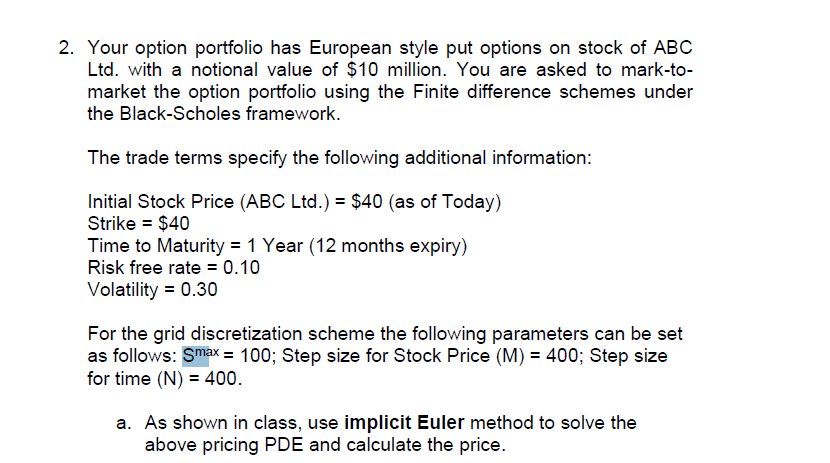

In [10]:
def implicit_fin_diff(S,K,T,sigma,r,N,Nj,CallPut):
    '''
    Implicit finite difference method for pricing European call and put options
        
    Args:
        S - intial price of underlying asset
        K - strike price
        T - time to maturity
        sigma - volatility
        r - risk-free rate
        
        N - number of time intervals (horizontal)
        Nj - number of partition points from 0 to the upper/lower boundary (vertical)
        CallPut - 'Call' or 'Put'
        
    Returns the option price estimated by the finite difference grid    
    
    '''
    dt = T/N;    #dx = sigma*np.sqrt(3*dt)
    Smax= 100
    dx = Smax/Nj
    nu = r - 0.5*sigma**2
    pu = -0.5*dt*((sigma/dx)**2 + nu/dx);   pm = 1.0 + dt*(sigma/dx)**2 + r*dt;    pd = -0.5*dt*((sigma/dx)**2 - nu/dx)
    grid = np.zeros(2*Nj+1)
    
    # Asset prices at maturity:
    St = [S*np.exp(-Nj*dx)]
    for j in range(1, 2*Nj+1):
        St.append(St[j-1]*np.exp(dx))
    
    # Option value at maturity:
    for j in range(2*Nj+1):
        if CallPut == 'Call':
            grid[j] = max(0, St[j] - K)
        elif CallPut == 'Put':
            grid[j] = max(0, K - St[j])
        # Boundary Conditions:
    if CallPut == 'Call':
        lambdaU = St[2*Nj] - St[2*Nj-1];    lambdaL = 0.0;
    elif CallPut == 'Put':
        lambdaU = 0.0;  lambdaL = -1.0*(St[1] - St[0])
    
    # Backwards computing through grid
    def tridiagonal(C,pU,pM,pD,lambda_L,lambda_U,nj):
        '''
        Helper function for solving the tridiagonal matrix system specified by the 
        implicit finite difference method
        '''
        C1 = np.zeros(2*nj+1)     
        pmp = [pM+pD]
        pp = [C[1]+pD*lambda_L]
        for j in range(2,2*nj):
            pmp.append(pM - pU*pD/pmp[j-2])
            pp.append(C[j] - pp[j-2]*pD/pmp[j-2])
        C1[2*nj] = (pp[len(pp)-1] + pmp[len(pmp)-1]*lambda_U)/(pU + pmp[len(pmp)-1])
        C1[2*nj-1] = C1[2*nj] - lambda_U
        for j in range(2*nj-2, -1, -1):
            C1[j] = (pp[j-1] - pU*C1[j+1])/pmp[j-1]
        C1[0] = C1[1] - lambda_L
        return C1
    
    for i in range(N):  
        grid = tridiagonal(grid,pu,pm,pd,lambdaL,lambdaU,Nj)
    
    return grid[Nj]        

In [11]:
EuropeanPut = implicit_fin_diff(40,40,1,0.3,0.1,400,400,'Put')
EuropeanPut

2.4483184375057845

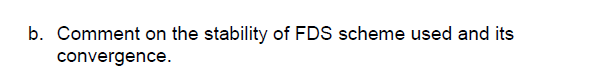

In [12]:
N = norm.cdf
def BS_PUT(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma* np.sqrt(T)
    return K*np.exp(-r*T)*N(-d2) - S*N(-d1)
PutOprice = BS_PUT(40, 40, 1, 0.1, 0.3)
PutOprice

2.8871501543930442

In [13]:
EuropeanVanillaPut = implicit_fin_diff(40,40,1,0.3,0.1,400,400,'Put')
EuropeanVanillaPut

2.4483184375057845

In [14]:
EuropeanVanillaPut = implicit_fin_diff(40,40,1,0.3,0.1,15000,30000,'Put')
EuropeanVanillaPut

# Ans:
## Stability
The Implicit Euler Finit difference scheme is stable if and only if infinity norm of tridiagonal matrix inverse is less than 1 then successive values of Forward Difference Scheme will converge to the finite or ana in Equation 3 get smaller and smaller, and hence the algorithm converges, or is stable. (Alternatively if the infinity norm of B -1 is greater than 1 then successive values of FDS schemes will get larger and larger and hence diverge.) The main aim should be keep ininity norm of the tridiaginal matrix as small as possible. This can be achived by taking very small dt. 


## Convergence
The Finite Difference Scheme will converge to analytical solution if the dt becomes very small like we have done abpve where we made timesteps very small which is in the tune of (1/15000) then you can see it is much better as compared to (1/400) timesteps which is called as dt. 
The error inacse where dt = (1/15000) is much lesser than (dt = 1/400), so we can conclude that lower the timesteps(i.e. dt)the better approximate the solution is.
If you make it infinitesimal less then the Finite difference Scheme will be converge to Analytical solution. The finite difference scheme will also converge to the analytical solution if the number of simulations for FDS are higher whoch will lead to more computations. But this is the trade-off since if you run using huge number of simulations then the time to produce the result also increased which might not be optimal since it proportinally increases with number of simulations to run.

The rate of convergence of the Finit Difference Schemes is directly related to the truncation error introduced when approximating the partial derivatives. Hence the implicit method converges at the rates of Ο(δt). This is the same convergence rate as the explicit method, but slower than the Crank-Nicolson method of Finite Difference Scheme. So convergence will be better if you use Crank-Nicolson method because it uses the average of explicit and implicit method.

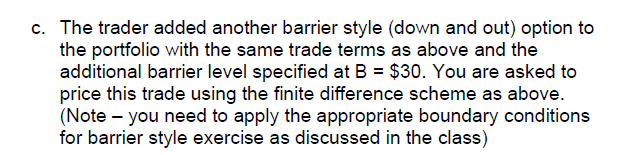

In [ ]:
S0 = 40.0  # spot stock price
K = 40.0  # strike
T = 1.0  # maturity
r = 0.1  # risk free rate
sig = 0.3  # diffusion coefficient or volatility
X0 = np.log(S0)  # logprice
B = 30  # Barrier 1


Nspace = 400  # M space steps
Ntime = 400  # N time steps
S_max = 100  # The max of S corresponds to the maximum boundary condition
S_min = 30 # The min of S corresponds to the Barrier which corresponds to minimum boundary condition

x_max = np.log(S_max)  # A2
x_min = np.log(S_min)  # A1

x, dx = np.linspace(x_min, x_max, Nspace, retstep=True)  # space discretization
T_array, dt = np.linspace(0, T, Ntime, retstep=True)  # time discretization
Payoff = np.maximum(K - np.exp(x), 0)  # Put Payoff

V = np.zeros((Nspace, Ntime))  # grid initialization
offset = np.zeros(Nspace - 2)  # vector to be used for the boundary terms

V[:, -1] = Payoff  # terminal conditions
V[-1, :] = 0  # boundary condition
V[0, :] = 0  # boundary condition

# construction of the tri-diagonal matrix D
sig2 = sig * sig
dxx = dx * dx
a = (dt / 2) * ((r - 0.5 * sig2) / dx - sig2 / dxx)
b = 1 + dt * (sig2 / dxx + r)
c = -(dt / 2) * ((r - 0.5 * sig2) / dx + sig2 / dxx)
D = sparse.diags([a, b, c], [-1, 0, 1], shape=(Nspace - 2, Nspace - 2)).tocsc()
DD = splu(D)

# Backward iteration
for i in range(Ntime - 2, -1, -1):
    offset[0] = a * V[0, i]
    offset[-1] = c * V[-1, i]
    V[1:-1, i] = DD.solve(V[1:-1, i + 1] - offset)

# finds the option at S0
oPrice = np.interp(X0, x, V[:, 0])
print("The price of the Down and Out Put option by PDE is: ", oPrice)

The price of the Down and Out Put option by PDE is:  0.5888346955319073
